In [ ]:
# STEP 1: Mount Google Drive & Unzip Dataset
from google.colab import drive
drive.mount('/content/drive')

!unzip -q "/content/drive/MyDrive/Oil_Spill_Project/dataset.zip" -d /content/oil_spill_data
!ls /content/oil_spill_data


Mounted at /content/drive
dataset  label_colors.txt  test  train	val


In [ ]:
# STEP 2: Import Libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import pandas as pd
from glob import glob
import random


In [ ]:
# STEP 3: Define Dataset Paths
base_dir = "/content/oil_spill_data"
train_img_dir = os.path.join(base_dir, "train/images")
train_mask_dir = os.path.join(base_dir, "train/masks")
val_img_dir = os.path.join(base_dir, "val/images")
val_mask_dir = os.path.join(base_dir, "val/masks")
test_img_dir = os.path.join(base_dir, "test/images")
test_mask_dir = os.path.join(base_dir, "test/masks")

IMG_SIZE = (256, 256)

In [ ]:
# STEP 4: Data Inspection
print("Dataset Structure:")
print("Train Images:", len(os.listdir(train_img_dir)))
print("Train Masks :", len(os.listdir(train_mask_dir)))
print("Val Images  :", len(os.listdir(val_img_dir)))
print("Val Masks   :", len(os.listdir(val_mask_dir)))
print("Test Images :", len(os.listdir(test_img_dir)))
print("Test Masks  :", len(os.listdir(test_mask_dir)))

Dataset Structure:
Train Images: 811
Train Masks : 811
Val Images  : 203
Val Masks   : 203
Test Images : 254
Test Masks  : 254


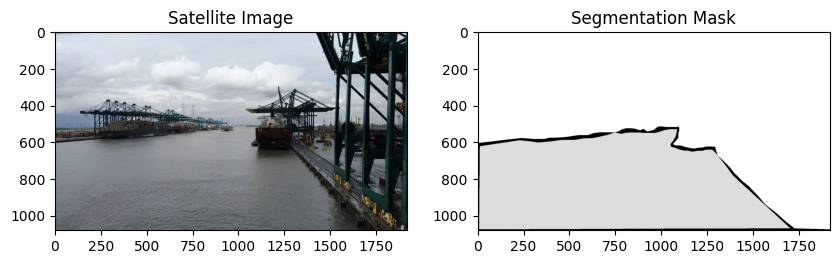

In [ ]:
# STEP 5: Visualize a Sample Image + Mask
random_img = random.choice(os.listdir(train_img_dir))
img = cv2.imread(os.path.join(train_img_dir, random_img))
mask = cv2.imread(os.path.join(train_mask_dir, random_img.replace(".jpg", ".png")), cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Satellite Image")

plt.subplot(1,2,2)
plt.imshow(mask, cmap='gray')
plt.title("Segmentation Mask")
plt.show()

In [ ]:
# STEP 6: Data Preprocessing Functions
def preprocess_image(image, size=(256,256)):
    image = cv2.resize(image, size)
    return image / 255.0

def preprocess_mask(mask, size=(256,256)):
    mask = cv2.resize(mask, size, interpolation=cv2.INTER_NEAREST)
    return (mask > 127).astype(np.uint8)

def load_data(img_dir, mask_dir, img_size=IMG_SIZE, limit=None):
    images, masks = [], []
    file_list = os.listdir(img_dir)
    if limit:
        file_list = file_list[:limit]
    for fname in file_list:
        img = cv2.imread(os.path.join(img_dir, fname))
        mask = cv2.imread(os.path.join(mask_dir, fname.replace(".jpg",".png")), cv2.IMREAD_GRAYSCALE)
        if img is not None and mask is not None:
            images.append(preprocess_image(img, img_size))
            masks.append(preprocess_mask(mask, img_size))
    return np.array(images), np.expand_dims(np.array(masks), -1)

In [ ]:
#  STEP 7: Load Train, Validation, and Test Data
X_train, y_train = load_data(train_img_dir, train_mask_dir, limit=200)
X_val, y_val = load_data(val_img_dir, val_mask_dir, limit=50)
X_test, y_test = load_data(test_img_dir, test_mask_dir, limit=100)

print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (200, 256, 256, 3) (200, 256, 256, 1)
Val: (50, 256, 256, 3) (50, 256, 256, 1)
Test: (100, 256, 256, 3) (100, 256, 256, 1)


In [ ]:
# STEP 8: Define U-Net Model
def unet_model(input_size=(256,256,3)):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)

    c2 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)

    c3 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2,2))(c3)

    # Bottleneck
    bn = layers.Conv2D(128, (3,3), activation='relu', padding='same')(p3)
    bn = layers.Conv2D(128, (3,3), activation='relu', padding='same')(bn)

    # Decoder
    u3 = layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(bn)
    u3 = layers.concatenate([u3, c3])
    c4 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(u3)
    c4 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c4)

    u2 = layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c4)
    u2 = layers.concatenate([u2, c2])
    c5 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(u2)
    c5 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(c5)

    u1 = layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(c5)
    u1 = layers.concatenate([u1, c1])
    c6 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(u1)
    c6 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(c6)

    outputs = layers.Conv2D(1, (1,1), activation='sigmoid')(c6)
    return models.Model(inputs, outputs)

In [ ]:
# STEP 9: Metrics & Compile Model
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(K.cast(y_true, 'float32'))
    y_pred_f = K.flatten(K.cast(y_pred, 'float32'))
    inter = K.sum(y_true_f * y_pred_f)
    return (2.*inter + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(K.cast(y_true, 'float32'))
    y_pred_f = K.flatten(K.cast(y_pred, 'float32'))
    inter = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - inter
    return (inter + smooth) / (union + smooth)

model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef, iou_coef, 'accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 256, 256,  │        448 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 256, 256,  │      2,320 │ conv2d_15[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 128, 128,  │          0 │ conv2d_16[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 128, 128,  │      4,640 │ max_pooling2d_3[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 128, 128,  │      9,248 │ conv2d_17[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ conv2d_18[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 64, 64,    │     36,928 │ conv2d_19[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_5[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 32, 32,    │    147,584 │ conv2d_21[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_3  │ (None, 64, 64,    │     32,832 │ conv2d_22[0][0]   │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 64, 64,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv2d_20[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 64, 64,    │     73,792 │ concatenate_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 64, 64,    │     36,928 │ conv2d_23[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 128, 128,  │      8,224 │ conv2d_24[0][0] 

 Total params: 482,033 (1.84 MB)

 Trainable params: 482,033 (1.84 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# --- STEP 10: Train Model ---
os.makedirs("/content/checkpoints", exist_ok=True)
checkpoint_path = "/content/checkpoints/unet_oilspill_best.h5"
cp = ModelCheckpoint(checkpoint_path, monitor='val_dice_coef', mode='max', save_best_only=True, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    batch_size=8, epochs=15,
                    callbacks=[cp, rlr], verbose=1)

Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9255 - dice_coef: 0.9043 - iou_coef: 0.8262 - loss: 0.1897
Epoch 1: val_dice_coef improved from -inf to 0.90089, saving model to /content/checkpoints/unet_oilspill_best.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.9256 - dice_coef: 0.9043 - iou_coef: 0.8263 - loss: 0.1897 - val_accuracy: 0.9117 - val_dice_coef: 0.9009 - val_iou_coef: 0.8210 - val_loss: 0.2133 - learning_rate: 3.9063e-06
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9312 - dice_coef: 0.9082 - iou_coef: 0.8328 - loss: 0.1834
Epoch 2: val_dice_coef improved from 0.90089 to 0.90175, saving model to /content/checkpoints/unet_oilspill_best.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.9310 - dice_coef: 0.9081 - iou_coef: 0.8326 - loss: 0.1836 - val_accuracy: 0.9123 - val_dice_coef: 0.9018 - val_iou_coef: 0.8224 - val_loss: 0.2120 - learning_rate: 3.9063e-06
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9280 - dice_coef: 0.9089 - iou_coef: 0.8338 - loss: 0.1864
Epoch 3: val_dice_coef improved from 0.90175 to 0.90189, saving model to /content/checkpoints/unet_oilspill_best.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.9280 - dice_coef: 0.9088 - iou_coef: 0.8336 - loss: 0.1864 - val_accuracy: 0.9127 - val_dice_coef: 0.9019 - val_iou_coef: 0.8226 - val_loss: 0.2112 - learning_rate: 3.9063e-06
Epoch 4/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9245 - dice_coef: 0.9050 - iou_coef: 0.8278 - loss: 0.1882
Epoch 4: val_dice_coef did not improve from 0.90189
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.9246 - dice_coef: 0.9050 - iou_coef: 0.8277 - loss: 0.1882 - val_accuracy: 0.9119 - val_dice_coef: 0.9015 - val_iou_coef: 0.8221 - val_loss: 0.2129 - learning_rate: 3.9063e-06
Epoch 5/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9190 - dice_coef: 0.9038 - iou_coef: 0.8255 - loss: 0.2018
Epoch 5: val_dice_coef did not improve from 0.90189
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.9194 - dice_coef: 0.9038 - iou_coef: 0.8255 - loss: 0.2013 - val_accuracy: 0.9129 - val_dice_coef: 0.9018 - val_iou_coef: 0.8225 - val


Epoch 6: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.9220 - dice_coef: 0.9029 - iou_coef: 0.8243 - loss: 0.1910 - val_accuracy: 0.9125 - val_dice_coef: 0.9019 - val_iou_coef: 0.8227 - val_loss: 0.2120 - learning_rate: 3.9063e-06
Epoch 7/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9245 - dice_coef: 0.9098 - iou_coef: 0.8357 - loss: 0.1884
Epoch 7: val_dice_coef did not improve from 0.90190
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.9246 - dice_coef: 0.9096 - iou_coef: 0.8355 - loss: 0.1884 - val_accuracy: 0.9122 - val_dice_coef: 0.9017 - val_iou_coef: 0.8224 - val_loss: 0.2126 - learning_rate: 1.9531e-06
Epoch 8/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9334 - dice_coef: 0.9104 - iou_coef: 0.8364 - loss: 0.1763
Epoch 8: val_dice_coef did not improve from 0.90190
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.9332 - dice_coef: 0.9102 - iou_coef: 0.8361 - loss: 0.17


Epoch 9: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.9251 - dice_coef: 0.9002 - iou_coef: 0.8196 - loss: 0.2010 - val_accuracy: 0.9126 - val_dice_coef: 0.9020 - val_iou_coef: 0.8228 - val_loss: 0.2117 - learning_rate: 1.9531e-06
Epoch 10/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9250 - dice_coef: 0.8923 - iou_coef: 0.8080 - loss: 0.2055
Epoch 10: val_dice_coef did not improve from 0.90197
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.9251 - dice_coef: 0.8927 - iou_coef: 0.8086 - loss: 0.2047 - val_accuracy: 0.9125 - val_dice_coef: 0.9020 - val_iou_coef: 0.8227 - val_loss: 0.2119 - learning_rate: 9.7656e-07
Epoch 11/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9246 - dice_coef: 0.9027 - iou_coef: 0.8251 - loss: 0.1875
Epoch 11: val_dice_coef did not improve from 0.90197
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.9247 - dice_coef: 0.9028 - iou_coef: 0.8252 - loss: 0


Epoch 12: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.9233 - dice_coef: 0.8993 - iou_coef: 0.8196 - loss: 0.1964 - val_accuracy: 0.9126 - val_dice_coef: 0.9021 - val_iou_coef: 0.8230 - val_loss: 0.2117 - learning_rate: 9.7656e-07
Epoch 13/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9222 - dice_coef: 0.8984 - iou_coef: 0.8164 - loss: 0.1925
Epoch 13: val_dice_coef did not improve from 0.90210
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.9224 - dice_coef: 0.8987 - iou_coef: 0.8169 - loss: 0.1923 - val_accuracy: 0.9125 - val_dice_coef: 0.9021 - val_iou_coef: 0.8229 - val_loss: 0.2118 - learning_rate: 4.8828e-07
Epoch 14/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9359 - dice_coef: 0.9086 - iou_coef: 0.8346 - loss: 0.1712
Epoch 14: val_dice_coef did not improve from 0.90210
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.9356 - dice_coef: 0.9085 - iou_coef: 0.8343 - loss: 

In [ ]:
# STEP 11: Save Model
save_path = "/content/drive/MyDrive/Oil_Spill_Project/unet_oilspill_final.h5"
model.save(save_path)
print("Model saved to:", save_path)

Model saved to: /content/drive/MyDrive/Oil_Spill_Project/unet_oilspill_final.h5


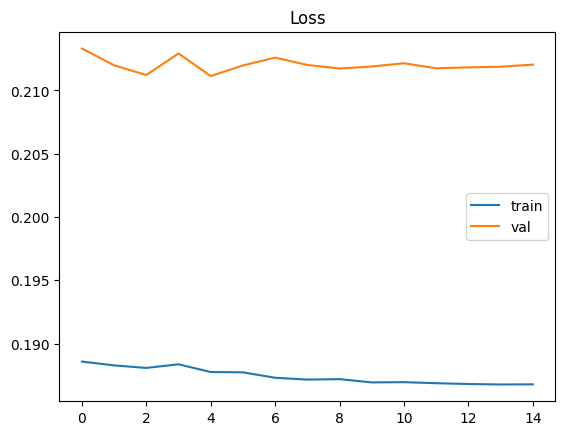

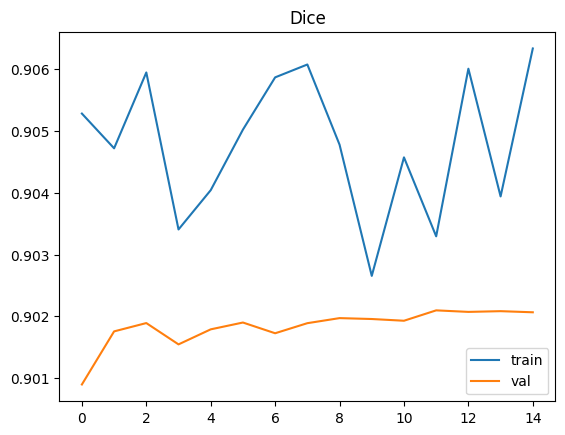

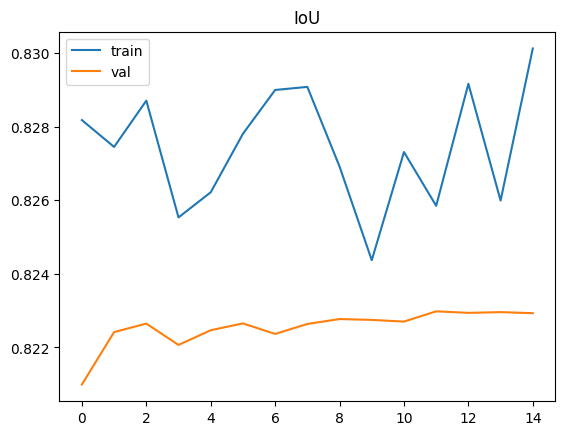

In [ ]:
# STEP 12: Plot Training Curves
plt.figure(); plt.plot(history.history['loss'], label='train'); plt.plot(history.history['val_loss'], label='val'); plt.legend(); plt.title("Loss"); plt.show()
plt.figure(); plt.plot(history.history['dice_coef'], label='train'); plt.plot(history.history['val_dice_coef'], label='val'); plt.legend(); plt.title("Dice"); plt.show()
plt.figure(); plt.plot(history.history['iou_coef'], label='train'); plt.plot(history.history['val_iou_coef'], label='val'); plt.legend(); plt.title("IoU"); plt.show()


In [ ]:
# STEP 13: Evaluate on Test Set
preds = model.predict(X_test, batch_size=8)
print("Predictions complete.")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predictions complete.


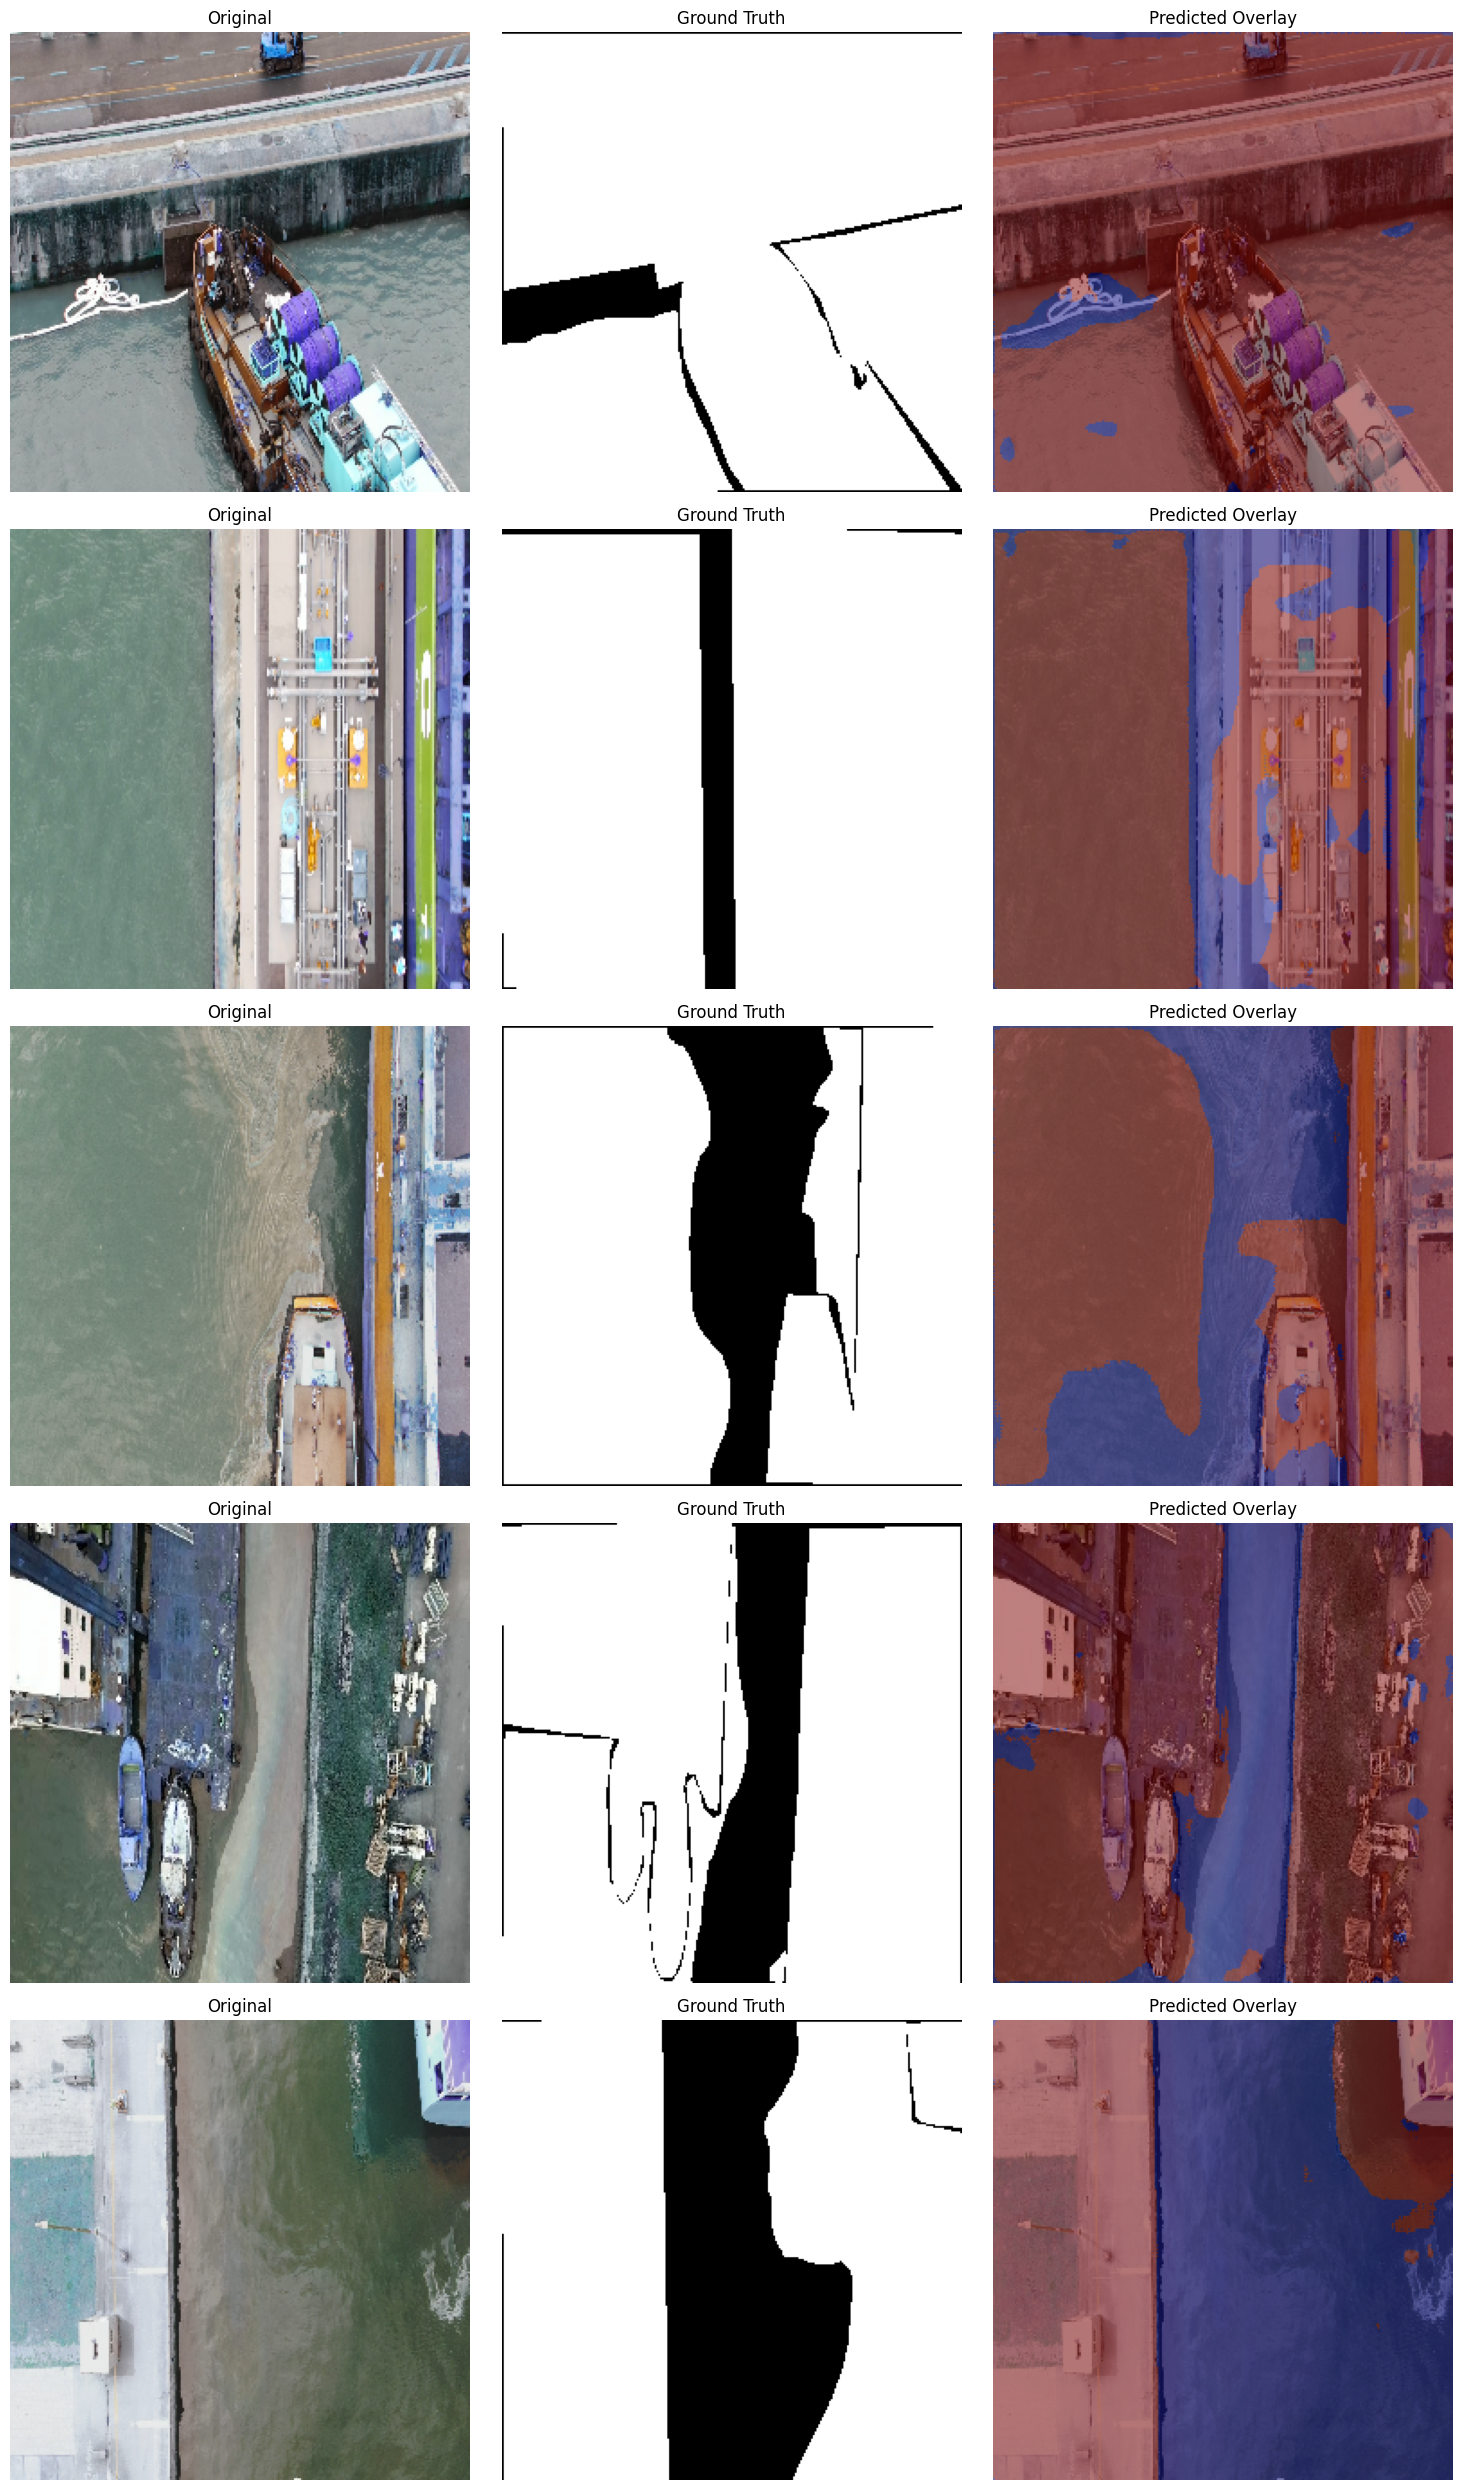

In [ ]:
# STEP 14: Visualize Predictions (Overlay)
def visualize_predictions(X, y_true, y_pred, num_samples=5):
    plt.figure(figsize=(15, num_samples*5))
    for i in range(num_samples):
        idx = random.randint(0, len(X)-1)
        plt.subplot(num_samples,3,i*3+1); plt.imshow(X[idx]); plt.title("Original"); plt.axis('off')
        plt.subplot(num_samples,3,i*3+2); plt.imshow(y_true[idx][:,:,0], cmap='gray'); plt.title("Ground Truth"); plt.axis('off')
        pred_mask = (y_pred[idx][:,:,0]>0.5).astype('uint8')
        plt.subplot(num_samples,3,i*3+3); plt.imshow(X[idx]); plt.imshow(pred_mask, cmap='jet', alpha=0.5); plt.title("Predicted Overlay"); plt.axis('off')
    plt.tight_layout(); plt.show()

visualize_predictions(X_test, y_test, preds, num_samples=5)

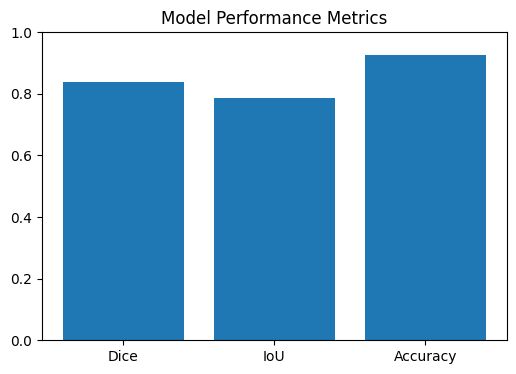

Pipeline Complete — Model trained, evaluated, and visualized successfully.


In [ ]:
# STEP 15: Compute Metrics
def compute_metrics(y_true, y_pred, thr=0.5):
    y_bin = (y_pred >= thr).astype(np.uint8)
    dices, ious = [], []
    for i in range(len(y_true)):
        gt = y_true[i].flatten(); pr = y_bin[i].flatten()
        inter = np.sum(gt * pr)
        union = np.sum(gt) + np.sum(pr) - inter
        dice = (2 * inter) / (np.sum(gt) + np.sum(pr) + 1e-6)
        iou = inter / (union + 1e-6)
        dices.append(dice); ious.append(iou)
    return np.mean(dices), np.mean(ious), dices, ious

mean_dice, mean_iou, dices, ious = compute_metrics(y_test, preds)
final_acc = history.history['accuracy'][-1]

metrics = {"Dice": mean_dice, "IoU": mean_iou, "Accuracy": final_acc}
plt.figure(figsize=(6,4))
plt.bar(metrics.keys(), metrics.values())
plt.ylim(0,1)
plt.title("Model Performance Metrics")
plt.show()

print("Pipeline Complete — Model trained, evaluated, and visualized successfully.")

In [ ]:
!pip install streamlit pyngrok opencv-python-headless tensorflow pillow matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 122.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 110.9 MB/s eta 0:00:00


In [ ]:
%%writefile app.py
import streamlit as st
import numpy as np
import cv2
import tensorflow as tf
from PIL import Image

# Load your trained model
model_path = "/content/drive/MyDrive/Oil_Spill_Project/unet_oilspill_final.h5"
model = tf.keras.models.load_model(model_path, compile=False)

# Streamlit UI
st.set_page_config(page_title="AI SpillGuard", page_icon="🛢️")
st.title("🛢️ AI SpillGuard - Oil Spill Detection")
st.write("Upload a satellite image to detect oil spill regions in real time.")

# File uploader
uploaded_file = st.file_uploader("📤 Upload a Satellite Image", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    # Read and display image
    image = Image.open(uploaded_file).convert("RGB")
    image_np = np.array(image)
    st.image(image_np, caption="🛰️ Uploaded Image", use_column_width=True)

    # Preprocess for model
    img_resized = cv2.resize(image_np, (256, 256)) / 255.0
    img_input = np.expand_dims(img_resized, axis=0)

    # Predict
    pred = model.predict(img_input)[0]
    pred_mask = (pred[:, :, 0] > 0.5).astype(np.uint8)

    # Overlay mask on image
    overlay = cv2.addWeighted(
        cv2.cvtColor((img_resized * 255).astype(np.uint8), cv2.COLOR_RGB2BGR),
        0.7,
        cv2.applyColorMap(pred_mask * 255, cv2.COLORMAP_JET),
        0.3,
        0
    )

    # Calculate spill percentage
    spill_area = np.sum(pred_mask)
    total_area = pred_mask.size
    spill_percent = (spill_area / total_area) * 100

    # Display results
    st.image(overlay, caption="Predicted Mask Overlay", use_column_width=True)
    st.write(f"🧮 **Estimated Oil Spill Coverage:** {spill_percent:.2f}%")

    if spill_percent > 10:
        st.error("⚠️ Significant oil spill detected!")
    else:
        st.success("✅ No major spill detected.")

st.markdown("---")
st.caption("Developed as part of AI SpillGuard - Week 7–8 Deployment Module")


Overwriting app.py


In [ ]:
from pyngrok import ngrok

# Paste your token here (replace the string below)
!ngrok authtoken "343hwp413nz2d418SXxF5vZbmGy_79h742gyJxdoNS9EdyXXC"

# Run Streamlit app
!streamlit run app.py &>/dev/null &

# Get public link
public_url = ngrok.connect(8501)
print("🌐 Streamlit App is Live! Click below:")
print(public_url)

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
🌐 Streamlit App is Live! Click below:
NgrokTunnel: "https://madden-unhesitating-unrefreshingly.ngrok-free.dev" -> "http://localhost:8501"
